In [1]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
# code_dir = '/Users/margarethenderson/Box Sync/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor, sketch_token_features
from feature_extraction import texture_statistics_pyramid2 as texture_statistics_pyramid
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting, arg_parser, merge_features, fwrf_fit, fwrf_predict

fpX = np.float32
# device = 'cpu:0'
device = initialize_fitting.init_cuda()

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [17]:
thing = torch.load('/user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_plus_sketch_tokens_stacked/Sep-28-2021_1821_00_DEBUG/all_fit_params')



In [18]:
thing['stack_result'][1]

array([-0.11677142, -0.10574128, -0.00305698, ..., -0.01937585,
       -0.00568796, -0.01261542])

In [2]:
# Testing fitting code
fitting_type='pyramid_texture_plus_sketch_tokens'
do_avg_pool=True
subject=1
volume_space = True
up_to_sess = 1
n_ori = 4
n_sf = 4
nonlin_fn = False
padding_mode = 'circular';
group_all_hl_feats = True; \
sample_batch_size = 50; voxel_batch_size = 100; \
zscore_features = True; ridge = True; \
shuffle_images = False; random_images = False; random_voxel_data = False; \
do_fitting = True; do_val = True; do_varpart = True; do_stack=True; date_str = None;
shuff_rnd_seed = 0; debug = True; \
do_pca_pyr_hl=False; do_pca_st=False; do_pca_st=False;  
min_pct_var = 99; max_pc_to_retain = 400; map_ind = -1; \
n_prf_sd_out = 2; mult_patch_by_prf = True; \
downsample_factor = 1.0; do_nms = False

In [3]:
if 'pyramid' in fitting_type:
    model_name = initialize_fitting.get_pyramid_model_name(ridge, n_ori, n_sf, do_pca_hl = do_pca_pyr_hl)
#         feature_types_exclude = []
    feature_types_exclude = ['pixel']
    name1 = 'pyramid_texture'

elif 'gabor_texture' in fitting_type:        
    model_name = initialize_fitting.get_gabor_texture_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = []
    name1 = 'gabor_texture'

elif 'gabor_solo' in fitting_type:        
    model_name = initialize_fitting.get_gabor_solo_model_name(ridge, n_ori, n_sf)
    feature_types_exclude = ['pixel', 'simple_feature_means', 'autocorrs', 'crosscorrs']
    name1 = 'gabor_solo'

elif 'bdcn' in fitting_type:
    model_name = initialize_fitting.get_bdcn_model_name(do_pca_bdcn, map_ind)   
    name1 = 'bdcn'

elif 'sketch_tokens' in fitting_type:
    model_name = initialize_fitting.get_sketch_tokens_model_name(do_pca_st)   
    name1 = 'sketch_tokens'

else:
    raise ValueError('your string for fitting_type was not recognized')

if 'plus_sketch_tokens' in fitting_type:
    model_name2 = initialize_fitting.get_sketch_tokens_model_name(do_pca_st)
    model_name = model_name + '_plus_' + model_name2
elif 'plus_bdcn' in fitting_type:
    model_name2 = initialize_fitting.get_bdcn_model_name(do_pca_bdcn, map_ind)
    model_name = model_name + '_plus_' + model_name2

if do_stack:
    model_name += '_stacked'

output_dir, fn2save = initialize_fitting.get_save_path(subject, volume_space, model_name, shuffle_images, random_images, random_voxel_data, debug, date_str)

# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, volume_space)

sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, sessions=sessions, \
                                                             voxel_mask=voxel_mask, volume_space=volume_space, \
                                                              zscore_betas_within_sess=zscore_betas_within_sess, \
                                                              shuffle_images=shuffle_images, random_images=random_images, \
                                                                                         random_voxel_data=random_voxel_data)


if 'gabor' in fitting_type or 'sketch_tokens' in fitting_type or 'pyramid' in fitting_type:
    # For this model, the features are pre-computed, so we will just load them rather than passing in images.
    # Going to pass the image indices (into 10,000 dim array) instead of images to fitting and val functions, 
    # which will tell which features to load.
    trn_stim_data = image_order_trn
    val_stim_data = image_order_val

# More params for fitting
holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    


Time Stamp: Sep-28-2021_1811_11

Will save final output file to /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf_plus_sketch_tokens_stacked/Sep-28-2021_1811_11_DEBUG/


Volume space: ROI defs are located at: /lab_data/tarrlab/common/datasets/NSD/nsddata/ppdata/subj01/func1pt8mm/roi

3794 voxels of overlap between kastner and prf definitions, using prf defs
unique values in retino labels:
[-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]
0 voxels of overlap between face and place definitions, using place defs
unique values in categ labels:
[-1.  0. 26. 27. 28. 30. 31. 32. 33.]
1535 voxels are defined (differently) in both retinotopic areas and category areas

14913 voxels are defined across all areas, and will be used for analysis

Loading numerical label/name mappings for all ROIs:
[1, 2, 3, 4, 5, 6, 7]
['V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4']
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15

In [4]:
trn_stim_data = trn_stim_data[0:100]
val_stim_data = val_stim_data[0:50]

trn_voxel_data = trn_voxel_data[0:100,0:60]
val_voxel_data = val_voxel_data[0:50,0:60]

holdout_size=20

In [5]:
# Set up the pyramid
compute_features = False
_fmaps_fn = texture_statistics_pyramid.steerable_pyramid_extractor(pyr_height = n_sf, n_ori = n_ori)
# Initialize the "texture" model which builds on first level feature maps
_feature_extractor = texture_statistics_pyramid.texture_feature_extractor(_fmaps_fn,sample_batch_size=sample_batch_size, \
                              subject=subject, feature_types_exclude=feature_types_exclude, n_prf_sd_out=n_prf_sd_out,\
                              aperture=aperture, do_varpart = do_varpart, \
                              group_all_hl_feats = group_all_hl_feats, compute_features = compute_features, \
                              do_pca_hl = do_pca_pyr_hl, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
                                                                          device=device)
feature_info = [_feature_extractor.feature_column_labels, _feature_extractor.feature_types_include]


map_resolution = 227
_feature_extractor2 = sketch_token_features.sketch_token_feature_extractor(subject, device, map_resolution=map_resolution, \
                                                                           aperture = aperture, \
                                                     n_prf_sd_out = n_prf_sd_out, \
                               batch_size=sample_batch_size, mult_patch_by_prf=mult_patch_by_prf, do_avg_pool = do_avg_pool,\
                                           do_pca = do_pca_st, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain)
_feature_extractor = merge_features.combined_feature_extractor([_feature_extractor, _feature_extractor2], \
                                                                   [name1,'sketch_tokens'], do_varpart = do_varpart)



Feature types to exclude from the model:
['pixel', 'pixel_stats']
[ True  True  True  True False False False False False False False False
 False]
Grouping lower level features:
['mean_magnitudes' 'mean_realparts' 'marginal_stats_lowpass_recons'
 'variance_highpass_resid']
Grouping higher level features:
['magnitude_feature_autocorrs' 'lowpass_recon_autocorrs'
 'highpass_resid_autocorrs' 'magnitude_within_scale_crosscorrs'
 'real_within_scale_crosscorrs' 'magnitude_across_scale_crosscorrs'
 'real_imag_across_scale_crosscorrs'
 'real_spatshift_within_scale_crosscorrs'
 'real_spatshift_across_scale_crosscorrs']


In [8]:
 # add an intercept
add_bias=True
# determines whether to shuffle before separating the nested heldout data for lambda and param selection. 
# always using true.
shuffle=True 
best_losses, best_lambdas, best_params, best_train_holdout_preds, holdout_trial_order = fit_fwrf_model(trn_stim_data, trn_voxel_data, \
                                               _feature_extractor, models, \
                                               lambdas, zscore=zscore_features, add_bias=add_bias, \
                                               voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, \
                                               shuffle=shuffle, shuff_rnd_seed=shuff_rnd_seed, device=device, \
                                               dtype=fpX, debug=debug)
trn_holdout_voxel_data_pred = best_train_holdout_preds
        

dtype = <class 'numpy.float32'>
device = cuda:0
trn_size = 80 (80.0%)
Computing a new random seed
Seeding random number generator: seed is 121828
(20, 60)
[ 0.80709505 -1.15641749  0.0264453  -0.39558113 -0.54220062  0.30317307
  0.93786377 -0.18291682]
Initializing for fitting
Clearing precomputed features from memory.
Initializing for fitting
Clearing features from memory
---------------------------------------


Getting features for prf 0: [x,y,sigma] is [-0.55 -0.55 0.0400]
Loading pre-computed features for models [0 - 49] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf_ORIG.h5py
Took 72.31873 seconds to load file
Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(100, 641)
Final size of features concatenated is [100 x 635]
Feature types included are:
['mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_re

In [9]:
val_cc, val_r2, val_voxel_data_pred  = validate_fwrf_model(best_params, models, val_voxel_data, \
                                                                                val_stim_data, _feature_extractor, \
                                   sample_batch_size=sample_batch_size, voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)
                                     

Clearing precomputed features from memory.
Clearing features from memory
Getting features for prf 0: [x,y,sigma] is [-0.55 -0.55 0.0400]
Loading pre-computed features for models [0 - 49] from /user_data/mmhender/features/pyramid_texture/S1_features_each_prf_4ori_4sf_ORIG.h5py
Took 74.99301 seconds to load file
Index into batch for prf 0: 0
Size of features array for this image set and prf is:
(50, 641)
Final size of features concatenated is [50 x 635]
Feature types included are:
['mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']
Final size of features concatenated is [50 x 635]
Final size of features concatenated is [50 x 635]
Loadi

In [11]:
trn_holdout_voxel_data = trn_voxel_data[holdout_trial_order,:]
print(trn_holdout_voxel_data[12:22,50])
    
stack_result, stack_result_lo, partial_models_used_for_stack, train_r2, train_cc  = \
    run_stacking(_feature_extractor, trn_holdout_voxel_data, val_voxel_data, \
                              trn_holdout_voxel_data_pred, val_voxel_data_pred, debug=debug)


[ 0.80709505 -1.15641749  0.0264453  -0.39558113 -0.54220062  0.30317307
  0.93786377 -0.18291682]
Subsets of features that are going into the stacking analysis:
['pyramid_texture_just_lower-level_no_other_modules', 'pyramid_texture_just_higher-level_no_other_modules', 'just_sketch_tokens']
Running stacking, feat_use is:
[0 1 2]
Solving for stacking weights for voxel 0 of 60
Stacking weights matrix is size:
(60, 3)
Solving for stacking weights for voxel 1 of 60
Computing performance of stacked models
Running stacking, feat_use is:
[1, 2]
Solving for stacking weights for voxel 0 of 60
Stacking weights matrix is size:
(60, 2)
Solving for stacking weights for voxel 1 of 60
Computing performance of stacked models
Running stacking, feat_use is:
[0, 2]
Solving for stacking weights for voxel 0 of 60
Stacking weights matrix is size:
(60, 2)
Solving for stacking weights for voxel 1 of 60
Computing performance of stacked models
Running stacking, feat_use is:
[0, 1]
Solving for stacking weights f

/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [16]:
stack_result[3][0:100]

array([-5.26315917e-02, -4.62908050e-02, -2.62408837e-03, -6.07615317e-02,
       -1.01287647e-02, -9.17175043e-02, -9.39392650e-02, -7.95202105e-02,
       -1.12732850e-02, -2.07749869e-03, -1.14126367e-02, -2.50766370e-02,
       -1.02011610e-01, -1.60518818e-02, -1.52835831e-02, -1.77044515e-02,
       -2.83743689e-03, -4.00177756e-04, -7.46232942e-03, -1.75062070e-03,
       -3.36067794e-03, -7.81333173e-02, -5.38365109e-02, -3.96638584e-02,
       -2.32216005e-03, -4.95832293e-02, -4.43139936e-02, -1.54228590e-02,
       -4.34484407e-02, -1.24379220e-02, -3.22776357e-03, -4.97895328e-02,
       -7.15954113e-02, -5.76862499e-02, -1.91732384e-02, -2.80904796e-03,
       -4.60958938e-02, -9.79228991e-02, -6.65136244e-02, -2.68351298e-02,
       -1.00542142e-02, -1.19577166e-02, -1.40260590e-01, -4.54332790e-02,
       -6.10647437e-03, -1.02578080e-02, -1.45051368e-02, -7.08481216e-02,
       -6.69709902e-03, -8.22444503e-03, -5.08720573e-03, -2.50734419e-04,
       -2.60339017e-02, -

In [17]:
n_voxels = trn_voxel_data.shape[1]

# To get the "features" to use for stacking - i'm using the "partial models" that are defined 
# by the feature extractor. The first one is the full model, so we don't want to use that - just want 
# the ones that include just a subset of the full feature space.
partial_masks, partial_version_names = _feature_extractor.get_partial_versions()
partial_models_use = []
hasattr(_feature_extractor, 'module_names')
for mm in range(len(_feature_extractor.module_names)):
    this_module = np.where([(_feature_extractor.module_names[mm] in pp) for pp in partial_version_names])[0]
    if len(this_module)>1:
        # this means there are 'subsets' of features within this module that we will want to consider separately.
        # so finding just the ones that we want here.
        partial_models_use += list(np.where([(_feature_extractor.module_names[mm] in pp and '_just' in pp and '_no_other_modules' in pp) \
                     for pp in partial_version_names])[0])
    else:
        partial_models_use += list(this_module)
print('Subsets of features that are going into the stacking analysis:')
print([partial_version_names[pp] for pp in partial_models_use])

n_feature_groups = len(partial_models_use)

# Creating a list where each element is predictions for one of the partial models - these will be 
# the 'features' elements input to stacking code.
preds_train = [trn_voxel_data_pred[:,:,pp].T for pp in partial_models_use]
preds_val = [val_voxel_data_pred[:,:,pp] for pp in partial_models_use]
# Compute trial-wise training errors
# each element of err is [ntrials x nvoxels]
train_err = [trn_voxel_data - trn_voxel_data_pred[:,:,pp].T for pp in partial_models_use]

# Also computing the performance of each of the partial versions on training set data.
# this is sort of a sanity check that things are working, since the performance of the partial models
# should roughly predict what the stacking weights will be.
train_r2 = np.array([get_r2(trn_voxel_data, trn_voxel_data_pred[:,:,pp].T) \
                     for pp in range(len(partial_version_names))]).T
train_r2 = np.nan_to_num(train_r2)
train_cc = np.array([get_corrcoef(trn_voxel_data, trn_voxel_data_pred[:,:,pp].T) \
                     for pp in range(len(partial_version_names))]).T
train_cc = np.nan_to_num(train_cc)

# First running stacking w all features included
feat_use = np.arange(0,n_feature_groups)
# Stack result will be a tuple including the stacking weights, performance.
# stack_result = stacked_core(feat_use, train_err, train_data=trn_voxel_data,\
#                  val_data = val_voxel_data, preds_train = preds_train, preds_val = preds_val,\
#                  debug=debug);

Subsets of features that are going into the stacking analysis:
['pyramid_texture_just_lower-level_no_other_modules', 'pyramid_texture_just_higher-level_no_other_modules', 'just_sketch_tokens']


In [109]:
[np.any(preds_val[pp][:,0:200]==0) for pp in range(7)]

IndexError: list index out of range

In [105]:
[np.any(val_voxel_data_pred[:,0:200,pp]==0) for pp in range(7)]

[False, False, False, False, False, False, False]

In [104]:
np.where(val_voxel_data_pred[0,:,0]==0)

(array([  200,   201,   202, ..., 14910, 14911, 14912]),)

In [64]:
partial_models_use

[2, 3, 6]

In [67]:
ti = 400
vi = 1000
trn_voxel_data[ti,vi] - trn_voxel_data_pred[vi,ti,6]

1.4491654355078936

In [68]:
train_err[2][ti,vi]

1.4491654355078936

In [72]:
np.mean(train_err[0] * train_err[1], axis=0)[0:10]

array([0.98496226, 1.01183355, 0.95645017, 1.01328482, 0.95244019,
       0.9404517 , 0.93954749, 0.95748219, 0.96806985, 0.98379155])

In [73]:
train_err[0].shape

(688, 14913)

In [70]:
P[0:10,0,1]

array([0.98496226, 1.01183355, 0.95645017, 1.01328482, 0.95244019,
       0.9404517 , 0.93954749, 0.95748219, 0.96806985, 0.98379155])

In [54]:
from __future__ import division
import sys
import time
import numpy as np
import copy
import torch
from cvxopt import matrix, solvers

from utils import numpy_utils, torch_utils


train_data = trn_voxel_data;
val_data = val_voxel_data;

solvers.options["show_progress"] = False

print('Running stacking, feat_use is:')
print(feat_use)
n_voxels = train_data.shape[1]
n_feature_groups = len(feat_use) # feat use is the sub-set of feature groups to stack.
n_trials_train = train_data.shape[0]
n_trials_val = preds_val[0].shape[0]

dtype = train_data.dtype
stacked_pred_train = np.full(fill_value=0, shape=(n_trials_train, n_voxels), dtype=dtype)
stacked_pred_val = np.full(fill_value=0, shape=(n_trials_val, n_voxels), dtype=dtype)

# calculate error matrix for stacking
P = np.zeros((n_voxels, n_feature_groups, n_feature_groups))
idI = 0
for i in feat_use:
    idJ = 0
    for j in feat_use:
        # err is the trialwise, voxelwise, error for each model.
        # P will store the summed products of the error for each pair of models 
        # (if i=j, then it's the summed squared error).
        P[:, idI, idJ] = np.mean(train_err[i] * train_err[j], 0)
        idJ += 1
    idI += 1

idI = 0
idJ = 0


Running stacking, feat_use is:
[0 1 2]


In [111]:
# PROGRAMATICALLY SET THIS FROM THE NUMBER OF FEATURES
q = matrix(np.zeros((n_feature_groups)))
G = matrix(-np.eye(n_feature_groups, n_feature_groups))
h = matrix(np.zeros(n_feature_groups))
A = matrix(np.ones((1, n_feature_groups)))
b = matrix(np.ones(1))

# Stacking weights will be stored here
S = np.zeros((n_voxels, n_feature_groups))

for vv in range(0, n_voxels):
    if debug and vv>1:
        continue

    print('Solving for stacking weights for voxel %d of %d'%(vv, n_voxels))
    PP = matrix(P[vv])
    # solve for stacking weights for every voxel
    # This essentially is minimizing the quantity x.T @ PP @ x, subject to the constraint that
    # the elements of x have to be positive, and have to sum to 1. 
    # x will be the weights for the stacking model.
    # Weights will be dependent on the error of each model individually (this is contained in PP).
    S[vv, :] = np.array(solvers.qp(PP, q, G, h, A, b)["x"]).reshape(n_feature_groups,)
    if vv==0:
        print('Stacking weights matrix is size:')
        print(S.shape)

    # Combine the predictions from the individual feature spaces for voxel i
    z = np.array([preds_val[feature_j][:, vv] for feature_j in feat_use])
    # multiply the predictions by S[vv,:]
    stacked_pred_val[:, vv] = np.dot(S[vv, :], z)

    # Same thing for the training trials
    z = np.array([preds_train[feature_j][:, vv] for feature_j in feat_use])
    stacked_pred_train[:, vv] = np.dot(S[vv, :], z)

    sys.stdout.flush()


Solving for stacking weights for voxel 0 of 14913
Stacking weights matrix is size:
(14913, 3)
Solving for stacking weights for voxel 1 of 14913


In [141]:
stacked_pred_train.shape

(688, 14913)

In [142]:
train_data.shape

(688, 14913)

In [125]:
z = np.array([preds_train[feature_j][:, vv] for feature_j in feat_use])
np.sum( S[vv,:] * z[:,0] )

0.0039898904395518926

In [126]:
d = np.dot(S[vv, :], z)
d[0]

0.0039898904395518926

In [130]:
z.shape

(3, 688)

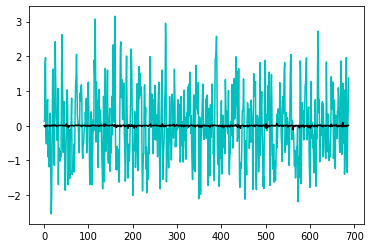

In [144]:
plt.figure;
# plt.plot(z[[1],:].T);
plt.plot(train_data[:, vv],'c')
plt.plot(stacked_pred_train[:, vv],'k')

In [151]:
actual = train_data[:, vv:vv+2]
predicted = stacked_pred_train[:, vv:vv+2]

ssres = np.sum((actual-predicted)**2, axis=0)
sstot = np.sum((actual - np.mean(actual, axis=0))**2, axis=0)
r2 = 1-(ssres/sstot)

r2

array([ 0.00410191, -0.00032977])

In [152]:
ssres = np.sum(np.power((predicted - actual),2), axis=0);
sstot = np.sum(np.power((actual - np.mean(actual, axis=0)),2), axis=0);
r2 = 1-(ssres/sstot)
r2  

array([ 0.00410191, -0.00032977])

In [154]:
get_r2(train_data[:,1:3], stacked_pred_train[:,1:3])

array([ 0.00410191, -0.00032977])

In [139]:
S[vv,:]

array([1.74853640e-06, 9.99997069e-01, 1.18233591e-06])

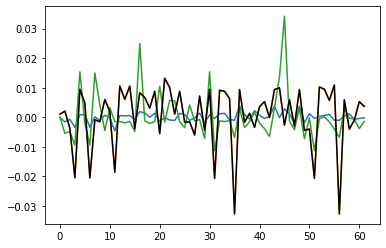

In [123]:
plt.figure;
plt.plot(z.T);
plt.plot(stacked_pred_val[:, vv],'k')

In [124]:
S[vv,:]

array([1.74853640e-06, 9.99997069e-01, 1.18233591e-06])

In [113]:
vv=1
z = np.array([preds_val[feature_j][:, vv] for feature_j in feat_use])

In [117]:
# z

In [89]:
np.array([preds_val[feature_j][:, vv] for feature_j in feat_use]).shape

(3, 62)

In [91]:
z = np.array([preds_val[feature_j][:, vv] for feature_j in feat_use])
z.shape

(3, 62)

In [90]:
S[vv, :].shape

(3,)

In [118]:
np.sum( S[vv,:] * z[:,0] )

0.0010613116374658625

In [119]:
d = np.dot(S[vv, :], z)
d[0]

0.0010613116374658625

In [85]:
np.array(solvers.qp(PP, q, G, h, A, b)["x"])

array([[1.74853640e-06],
       [9.99997069e-01],
       [1.18233591e-06]])

In [77]:
S[1,:]

array([1.74853640e-06, 9.99997069e-01, 1.18233591e-06])

In [82]:
np.array(b)

array([[1.]])

In [58]:
train_err[0][0:10,0]

array([-0.28985824, -0.00172333,  0.72818593,  1.66770975, -0.80773051,
       -1.04650661, -0.03157353,  0.59092905,  1.02570213,  0.41884224])

In [59]:
train_err[1][0:10,0]

array([-0.32472779, -0.07617345,  0.62728888,  1.59864692, -0.82370633,
       -1.06031112,  0.17408476,  0.63630368,  0.96768875,  0.45144197])

In [60]:
train_err[2][0:10,0]

array([-0.32739561, -0.07287778,  0.65540668,  1.57803739, -0.86243693,
       -1.01823853,  0.14716078,  0.63106169,  0.89224941,  0.45367834])

In [52]:
trn_voxel_data_pred.shape

(14913, 688, 7)

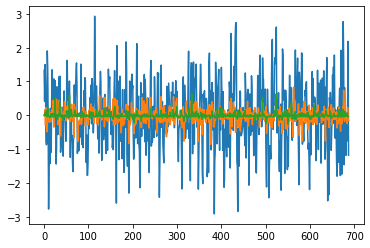

In [50]:
import matplotlib.pyplot as plt
plt.figure();
vind=1000
plt.plot(trn_voxel_data[0:1000,vind])
plt.plot(trn_voxel_data_pred[vind,0:1000,2])
# plt.plot(trn_voxel_data_pred[vind,0:1000,2])
plt.plot(trn_voxel_data_pred[vind,0:1000,6])

In [6]:
import sys
import time
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

from utils import numpy_utils, torch_utils, texture_utils

"""
General code for fitting a 'feature weighted receptive field' model to fmri data - looping over many candidate pRF 
models for each voxel, find a set of weights that best predict its responses based on feature space of interest.
Can work for many different types of feature spaces, feature extraction implemented with nn.Module.

Original source of some of this code is the github repository:
https://github.com/styvesg/nsd
It was modified by MH to work for this project.
"""


def _cofactor_fn_cpu(_x, lambdas):
    '''
    Generating a matrix needed to solve ridge regression model for each lambda value.
    Ridge regression (Tikhonov) solution is :
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    This func will return (X^T*X + I*lambda)^-1 * X^T. 
    So once we have that, can just multiply by training data (Y) to get weights.
    returned size is [nLambdas x nFeatures x nTrials]
    This version makes sure that the torch inverse operation is done on the cpu, and in floating point-64 precision.
    Otherwise get bad results for small lambda values. This seems to be a torch-specific bug, noted around May 2021.
    
    '''
    device_orig = _x.device
    type_orig = _x.dtype
    # switch to this specific format which works with inverse
    _x = _x.to('cpu').to(torch.float64)
    _f = torch.stack([(torch.mm(torch.t(_x), _x) + torch.eye(_x.size()[1], device='cpu', dtype=torch.float64) * l).inverse() for l in lambdas], axis=0) 
    
    # [#lambdas, #feature, #feature] 
    cof = torch.tensordot(_f, _x, dims=[[2],[1]]) # [#lambdas, #feature, #sample]
    
    # put back to whatever way it was before, so that we can continue with other operations as usual
    return cof.to(device_orig).to(type_orig)



def _loss_fn(_cofactor, _vtrn, _xout, _vout):
    '''
    Calculate loss given "cofactor" from cofactor_fn, training data, held-out design matrix, held out data.
    returns weights (betas) based on equation
    w = (X^T*X + I*lambda)^-1 * X^T * Y
    also returns loss for these weights w the held out data. SSE is loss func here.
    '''

    _beta = torch.tensordot(_cofactor, _vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]
    _pred = torch.tensordot(_xout, _beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
    _loss = torch.sum(torch.pow(_vout[:,None,:] - _pred, 2), dim=0) # [#lambdas, #voxels]
    return _beta, _loss, _pred



def fit_fwrf_model(images, voxel_data, _feature_extractor, prf_models, lambdas, \
                   zscore=False, add_bias=False, voxel_batch_size=100, holdout_size=100, \
                       shuffle=True, shuff_rnd_seed=0, device=None, dtype=np.float32, debug=False):
    
    """
    Solve for encoding model weights using ridge regression.
    Inputs:
        images: the training images, [n_trials x 1 x height x width]
            OR for models where features were pre-computed, this is a list of indices [n_trials,] into the 10,000 long feature array.
        voxel_data: the training voxel data, [n_trials x n_voxels]
        _feature_extractor_fn: module that maps from images to model features
        prf_models: the list of possible pRFs to test, columns are [x, y, sigma]
        lambdas: ridge lambda parameters to test
        zscore: want to zscore each column of feature matrix before fitting?
        add_bias: add a column of ones to feature matrix, for an additive bias?
        voxel_batch_size: how many voxels to use at a time for model fitting
        holdout_size: how many training trials to hold out for computing loss/lambda selection?
        shuffle: do we shuffle training data order before holding trials out?      
        shuff_rnd_seed: if we do shuffle training data (shuffle=True), what random seed to use? if zero, choose a new random seed in this code.
        device: what device to use? cpu/cuda
        debug: want to run a shortened version of this, to test it?
    Outputs:
        best_losses: loss value for each voxel (with best pRF and best lambda), eval on held out set
        best_lambdas: best lambda for each voxel (chosen based on loss w held out set)
        best_params: 
            [0] best pRF for each voxel [x,y,sigma]
            [1] best weights for each voxel/feature
            [2] if add_bias=True, best bias value for each voxel
            [3] if zscore=True, the mean of each feature before z-score
            [4] if zscore=True, the std of each feature before z-score
            [5] index of the best pRF for each voxel (i.e. index of row in "prf_models")
        
    """

    if device is None:
        device=torch.device('cpu:0')

    print ('dtype = %s' % dtype)
    print ('device = %s' % device)

    n_trials = len(images)
    n_prfs = len(prf_models)
    n_voxels = voxel_data.shape[1]   

    # Get train/holdout splits.
    # Held-out data here is used for lamdba selection.
    # This is the inner part of nested cross-validation; there is another portion of data ('val') which never enters this function.
    trn_size = n_trials - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxel_data)))
    order = np.arange(len(voxel_data), dtype=int)
    if shuffle:
        if shuff_rnd_seed==0:
            print('Computing a new random seed')
            shuff_rnd_seed = int(time.strftime('%M%H%d', time.localtime()))
        print('Seeding random number generator: seed is %d'%shuff_rnd_seed)
        np.random.seed(shuff_rnd_seed)
        np.random.shuffle(order)
        
    images = images[order]
    
    train_trial_order = order[:trn_size]
    holdout_trial_order = order[trn_size:]

    trn_data = copy.deepcopy(voxel_data[train_trial_order,:])
    out_data = copy.deepcopy(voxel_data[holdout_trial_order,:])
    
    print(out_data.shape)
    print(out_data[12:22,50])
    
    # Here is where any model-specific additional initialization steps are done
    # Includes initializing pca params arrays, if doing pca
    if len(images.shape)>1:
        image_size = images.shape[2:4]
    else:
        image_size = None
    _feature_extractor.init_for_fitting(image_size, prf_models, dtype)
    max_features = _feature_extractor.max_features

    # Decide whether to do any "partial" versions of the models (leaving out subsets of features)
    # Purpose is for variance partition
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    n_partial_versions = len(partial_version_names) # will be one if skipping varpart
    if add_bias:
        masks = np.concatenate([masks, np.ones([masks.shape[0],1])], axis=1) # always include intercept 
    masks = np.transpose(masks)
    # masks is [n_features_total (including intercept) x n_partial_versions]

    # Initialize arrays to store model fitting params
    best_w_params = np.zeros(shape=(n_voxels, max_features ,n_partial_versions), dtype=dtype)
    best_prf_models = np.full(shape=(n_voxels,n_partial_versions), fill_value=-1, dtype=int)   
    best_lambdas = np.full(shape=(n_voxels,n_partial_versions), fill_value=-1, dtype=int)
    best_losses = np.full(fill_value=np.inf, shape=(n_voxels,n_partial_versions), dtype=dtype)

    # Initialize arrays to store the trial-wise predictions (need these for stacking)
    # Using JUST the held out trials here so the errors are always cross-validated
    best_train_holdout_preds = np.zeros(shape=(n_voxels, holdout_size, n_partial_versions), dtype=dtype)

    # Additional params that are optional
    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.zeros(shape=(n_voxels,1,n_partial_versions), dtype=dtype)], axis=1)

    if zscore:
        features_mean = np.zeros(shape=(n_voxels, max_features), dtype=dtype)
        features_std  = np.zeros(shape=(n_voxels, max_features), dtype=dtype)
    else:
        features_mean = None
        features_std = None

    start_time = time.time()
    vox_loop_time = 0

    print ('---------------------------------------\n')
    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # Looping over prf_models (here prf_models are different spatial RF definitions)
        for m,(x,y,sigma) in enumerate(prf_models):
            if debug and m>1:
                break
                
            print('\nGetting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(m, prf_models[m,0],  prf_models[m,1],  prf_models[m,2]))

            t = time.time()            

            # Get features for the desired pRF, across all trn set image  
            # Features is size [ntrials x nfeatures]
            # nfeatures may be less than max_features, because max_features is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            features, feature_inds_defined = _feature_extractor(images, (x,y,sigma), m, fitting_mode=True)
            features = features.detach().cpu().numpy() 
            
            elapsed = time.time() - t

            n_features_actual = features.shape[1]
            
            if zscore:  
                features_m = np.mean(features, axis=0, keepdims=True) #[:trn_size]
                features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
                features -= features_m
                features /= features_s    

            if add_bias:
                features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
                feature_inds_defined = np.concatenate((feature_inds_defined, [True]), axis=0)
                
            trn_features = features[:trn_size,:]
            out_features = features[trn_size:,:]
            
            
            # Going to keep track of whether current prf is better than running best, for each voxel.
            # This is for the full model only.
            # Will use this to make sure for each partial model, we end up saving the params for the prf that was best w full model.
            full_model_improved = np.zeros((n_voxels,),dtype=bool)

            # Looping over versions of model w different features set to zero (variance partition)
            for pp in range(n_partial_versions):

                print('\nFitting version %d of %d: %s, '%(pp, n_partial_versions, partial_version_names[pp]))

                # nonzero_inds_full is length max_features (or max_features+1 if bias=True)
                # same size as the final params matrices will be.
                nonzero_inds_full = np.logical_and(masks[:,pp], feature_inds_defined)             
                # nonzero_inds_full is restricted to just indices that are defined for this prf - ie same size as features.
                nonzero_inds_short = masks[feature_inds_defined,pp]==1
        
                # Send matrices to gpu    
                _xtrn = torch_utils._to_torch(trn_features[:, nonzero_inds_short], device=device)
                _xout = torch_utils._to_torch(out_features[:, nonzero_inds_short], device=device)   

                # Do part of the matrix math involved in ridge regression optimization out of the loop, 
                # because this part will be same for all the voxels.
                _cof = _cofactor_fn_cpu(_xtrn, lambdas = lambdas) 

                # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
                vox_start = time.time()
                vi=-1
                for rv,lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
                    vi=vi+1
                    sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, n_prfs, rv[0], rv[-1], n_voxels))

                    # Send matrices to gpu
                    _vtrn = torch_utils._to_torch(trn_data[:,rv], device=device)
                    _vout = torch_utils._to_torch(out_data[:,rv], device=device)

                    # Here is where optimization happens - relatively simple matrix math inside loss fn.
                    _betas, _loss, _pred_out = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel], [trials x lambdas x voxels]
                    # Keep trial-by-trial predictions for each held-out set trial (need for stacking)
                    pred_out = torch_utils.get_value(_pred_out) 
                    # Note these trials are still in their SHUFFLED order, so we when we want to get R2 
                    # will need to make the actual data match this order.
            
                    
                    
#                     _pred_train = torch.tensordot(_xtrn, _betas, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
#                     _pred_out = torch.tensordot(_xout, _betas, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
#                     pred_train = torch_utils.get_value(_pred_train)
                    
                    # Going to combine the training and held out trials and re-create their original order here.
#                     preds_all_shuffled = np.concatenate((pred_train, pred_out), axis=0)
#                     preds_all_origorder = numpy_utils.unshuffle(preds_all_shuffled, order) # [#samples x lambdas x voxels]
    
                    # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
                    # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

                    # choose best lambda value and the loss that went with it.
                    _loss_values, _lambda_index = torch.min(_loss, dim=0)
                    loss_values, lambda_index = torch_utils.get_value(_loss_values), torch_utils.get_value(_lambda_index)
                    betas = torch_utils.get_value(_betas)
                    
                    if pp==0:

                        # comparing this loss to the other prf_models for each voxel (e.g. the other RF position/sizes)
                        assert(partial_version_names[pp]=='full_model' or partial_version_names[pp]=='full_combined_model')               
                        imp = loss_values<best_losses[rv,pp]
                        full_model_improved[rv] = imp

                    else:

                        # for the partial models we don't actually care which was best for the partial model itself,
                        # just care what was best for the full model
                        imp = full_model_improved[rv]


                    if np.sum(imp)>0:

                        # for whichever voxels had improvement relative to previous prf_models, save parameters now
                        # this means we won't have to save all params for all prf_models, just best.
                        arv = np.array(rv)[imp]

                        lambda_inds = lambda_index[imp]
                        best_lambdas[arv,pp] = lambda_inds
                        best_losses[arv,pp] = loss_values[imp]                        
                        best_prf_models[arv,pp] = m
                        if zscore and pp==0:
                            
                            # only need to update the mean/std if we're working with the full model, because those will be same for all partial versions.
                            fmean_tmp = copy.deepcopy(features_mean[arv,:])
                            fstd_tmp = copy.deepcopy(features_std[arv,:])
                            fmean_tmp[:,nonzero_inds_full[0:-1]] = features_m[0,nonzero_inds_short[0:-1]] # broadcast over updated voxels
                            fmean_tmp[:,~nonzero_inds_full[0:-1]] = 0.0
                            fstd_tmp[:,nonzero_inds_full[0:-1]] = features_s[0,nonzero_inds_short[0:-1]] # broadcast over updated voxels
                            fstd_tmp[:,~nonzero_inds_full[0:-1]] = 0.0
                            features_mean[arv,:] = fmean_tmp
                            features_std[arv,:] = fstd_tmp
                            
                        # taking the weights associated with the best lambda value
                        # remember that they won't fill entire matrix, rest of values stay at zero
                        best_w_tmp = copy.deepcopy(best_w_params[arv,:,pp])
                        best_w_tmp[:,nonzero_inds_full] = numpy_utils.select_along_axis(betas[:,:,imp], lambda_inds, \
                                                                                        run_axis=2, choice_axis=0).T
                        best_w_tmp[:,~nonzero_inds_full] = 0.0 # make sure to fill zeros here
                        best_w_params[arv,:,pp] = best_w_tmp
                        
                        # Save the trialwise predictions for all trials in their original order.
                        # Choosing predictions from whichever lambda was best.
                        best_train_holdout_preds[arv,:,pp] = numpy_utils.select_along_axis(pred_out[:,:,imp], \
                                                                               lambda_inds, run_axis=2, choice_axis=1).T;

                vox_loop_time += (time.time() - vox_start)
                elapsed = (time.time() - vox_start)
                sys.stdout.flush()

    # Print information about how fitting went...
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,0:max_features,:],]
    if add_bias:
        return_params += [best_w_params[:,-1,:],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / n_voxels))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / n_voxels))
    print ('setup throughput = %fs/model' % (inv_time / n_prfs))
    
    # This step clears the big feature maps for training data from feature extractor (no longer needed)
    _feature_extractor.clear_big_features()
    
    best_params = [prf_models[best_prf_models],]+return_params+[features_mean, features_std]+[best_prf_models]
    sys.stdout.flush()

    return best_losses, best_lambdas, best_params, best_train_holdout_preds, holdout_trial_order

In [7]:
from __future__ import division
import sys
import time
import numpy as np
import copy
import torch
from cvxopt import matrix, solvers

from utils import numpy_utils, torch_utils


def get_r2(actual,predicted):
    """
    This computes the coefficient of determination (R2).
    Always goes along first dimension (i.e. the trials/samples dimension)
    MAKE SURE INPUTS ARE ACTUAL AND THEN PREDICTED, NOT FLIPPED
    """
    ssres = np.sum(np.power((predicted - actual),2), axis=0);
    sstot = np.sum(np.power((actual - np.mean(actual, axis=0)),2), axis=0);
    r2 = 1-(ssres/sstot)
    
    return r2

def get_corrcoef(actual,predicted,dtype=np.float32):
    """
    This computes the linear correlation coefficient.
    Always goes along first dimension (i.e. the trials/samples dimension)
    Assume input is 2D.
    """
    assert(len(actual.shape)==2)
    vals_cc = np.full(fill_value=0, shape=(actual.shape[1],), dtype=dtype)
    for vv in range(actual.shape[1]):
        vals_cc[vv] = np.corrcoef(actual[:,vv], predicted[:,vv])[0,1] 
    return vals_cc
 
def validate_fwrf_model(best_params, prf_models, voxel_data, images, _feature_extractor, \
                                   sample_batch_size=100, voxel_batch_size=100, debug=False, dtype=np.float32):
    
    """ 
    Evaluate trained model, leaving out a subset of features at a time.
    """
    
    params = best_params
    device = _feature_extractor.device
    
    n_trials, n_voxels = len(images), len(params[0])
    n_prfs = prf_models.shape[0]
    n_features = params[1].shape[1]  
    n_voxels = np.shape(voxel_data)[1]

    best_models, weights, bias, features_mt, features_st, best_model_inds = params
    masks, partial_version_names = _feature_extractor.get_partial_versions()
    masks = np.transpose(masks)    
    n_features_max = _feature_extractor.max_features
    n_partial_versions = len(partial_version_names)
    
    # val_cc is the correlation coefficient bw real and predicted responses across trials, for each voxel.
    val_cc  = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)
    val_r2 = np.zeros(shape=(n_voxels, n_partial_versions), dtype=dtype)

    pred_models = np.full(fill_value=0, shape=(n_trials, n_features_max, n_prfs), dtype=dtype)
    feature_inds_defined_each_prf = np.full(fill_value=0, shape=(n_features_max, n_prfs), dtype=bool)
    
    # Saving full trial-by-trial predictions for each voxel, each partial model.
    # Need these for stacking.
    pred_voxel_data = np.full(fill_value=0, shape=(n_trials, n_voxels, n_partial_versions), dtype=dtype)
    
    start_time = time.time()    
    with torch.no_grad(): # make sure local gradients are off to save memory
        
        # First gather texture features for all pRFs.
        
        _feature_extractor.clear_big_features()
        
        for mm in range(n_prfs):
            if mm>1 and debug:
                break
            print('Getting features for prf %d: [x,y,sigma] is [%.2f %.2f %.4f]'%(mm, prf_models[mm,0],  prf_models[mm,1],  prf_models[mm,2] ))
            # all_feat_concat is size [ntrials x nfeatures]
            # nfeatures may be less than n_features_max, because n_features_max is the largest number possible for any pRF.
            # feature_inds_defined is length max_features, and tells which of the features in max_features are includes in features.
            all_feat_concat, feature_inds_defined = _feature_extractor(images, prf_models[mm,:], mm, fitting_mode=False)
            
            pred_models[:,feature_inds_defined,mm] = torch_utils.get_value(all_feat_concat)
            feature_inds_defined_each_prf[:,mm] = feature_inds_defined
            
        _feature_extractor.clear_big_features()
        
        vv=-1
        ## Looping over voxels here in batches, will eventually go through all.
        for rv, lv in numpy_utils.iterate_range(0, n_voxels, voxel_batch_size):
            vv=vv+1
            print('Getting predictions for voxels [%d-%d] of %d'%(rv[0],rv[-1],n_voxels))

            if vv>1 and debug:
                break

            # Looping over versions of model w different features set to zero (variance partition)
            for pp in range(n_partial_versions):

                print('\nEvaluating version %d of %d: %s'%(pp, n_partial_versions, partial_version_names[pp]))

                # masks describes the indices of the features that are included in this partial model
                # n_features_max in length
                features_to_use = masks[:,pp]==1
                print('Includes %d features'%np.sum(features_to_use))

                # [trials x features x voxels]
                features_full = pred_models[:,:,best_model_inds[rv,pp]]
                # Take out the relevant features now
                features_full = features_full[:,features_to_use,:]
                # Note there may be some zeros in this matrix, if we used fewer than the max number of features.
                # But they are zero in weight matrix too, so turns out ok.

                _weights = torch_utils._to_torch(weights[rv,:,pp], device=device)   
                _weights = _weights[:, features_to_use]
                _bias = torch_utils._to_torch(bias[rv,pp], device=device)

                print('number of zeros:')
                print(np.sum(features_full[0,:,0]==0))

                print('size of weights is:')
                print(_weights.shape)

                if features_mt is not None:
                    _features_m = torch_utils._to_torch(features_mt[rv,:], device=device)
                    _features_m = _features_m[:,features_to_use]
                if features_st is not None:
                    _features_s = torch_utils._to_torch(features_st[rv,:], device=device)
                    _features_s = _features_s[:,features_to_use]

                pred_block = np.full(fill_value=0, shape=(n_trials, lv), dtype=dtype)

                # Now looping over validation set trials in batches
                for rt, lt in numpy_utils.iterate_range(0, n_trials, sample_batch_size):

                    _features = torch_utils._to_torch(features_full[rt,:], device=device) # trials x features
                    if features_mt is not None:    
                        # features_m is [nvoxels x nfeatures] - need [trials x features x voxels]
                        _features = _features - torch.tile(torch.unsqueeze(_features_m, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])

                    if features_st is not None:
                        _features = _features/torch.tile(torch.unsqueeze(_features_s, dim=0), [_features.shape[0], 1, 1]).moveaxis([1],[2])
                        # if any entries in std are zero or nan, this gives bad result - fix these now.
                        # these bad entries will also be zero in weights, so doesn't matter. just want to avoid nans.
                        _features[torch.isnan(_features)] = 0.0 
                        _features[torch.isinf(_features)] = 0.0
                        
                    # features is [#samples, #features, #voxels] - swap dims to [#voxels, #samples, features]
                    _features = torch.transpose(torch.transpose(_features, 0, 2), 1, 2)
                    # weights is [#voxels, #features]
                    # _r will be [#voxels, #samples, 1] - then [#samples, #voxels]

                    _r = torch.squeeze(torch.bmm(_features, torch.unsqueeze(_weights, 2)), dim=2).t() 

                    if _bias is not None:
                        _r = _r + torch.tile(torch.unsqueeze(_bias, 0), [_r.shape[0],1])

                    pred_block[rt] = torch_utils.get_value(_r) 
                
                # Making sure to save these so that we can get stacking performance later.
                pred_voxel_data[:,rv,pp] = pred_block
                
                # Now for this batch of voxels and this partial version of the model, measure performance.
                val_cc[rv,pp] = get_corrcoef(voxel_data[:,rv], pred_block)
                val_r2[rv,pp] = get_r2(voxel_data[:,rv], pred_block)

                sys.stdout.flush()

    # any nans become zeros here.
    val_cc = np.nan_to_num(val_cc)
    val_r2 = np.nan_to_num(val_r2) 
    
    return val_cc, val_r2, pred_voxel_data


def run_stacking(_feature_extractor, trn_holdout_voxel_data, val_voxel_data, trn_holdout_voxel_data_pred, val_voxel_data_pred, debug=False):   
    """
    Get data organized to run stacking code (stacked_core)
    """
    n_voxels = trn_holdout_voxel_data.shape[1]

    # To get the "features" to use for stacking - i'm using the "partial models" that are defined 
    # by the feature extractor. The first one is the full model, so we don't want to use that - just want 
    # the ones that include just a subset of the full feature space.
    partial_masks, partial_version_names = _feature_extractor.get_partial_versions()
    partial_models_use = []
    hasattr(_feature_extractor, 'module_names')
    for mm in range(len(_feature_extractor.module_names)):
        this_module = np.where([(_feature_extractor.module_names[mm] in pp) for pp in partial_version_names])[0]
        if len(this_module)>1:
            # this means there are 'subsets' of features within this module that we will want to consider separately.
            # so finding just the ones that we want here.
            partial_models_use += list(np.where([(_feature_extractor.module_names[mm] in pp and '_just' in pp and '_no_other_modules' in pp) \
                         for pp in partial_version_names])[0])
        else:
            partial_models_use += list(this_module)
    print('Subsets of features that are going into the stacking analysis:')
    print([partial_version_names[pp] for pp in partial_models_use])

    n_feature_groups = len(partial_models_use)

    # Creating a list where each element is predictions for one of the partial models - these will be 
    # the 'features' elements input to stacking code.
    preds_train = [trn_holdout_voxel_data_pred[:,:,pp].T for pp in partial_models_use]
    preds_val = [val_voxel_data_pred[:,:,pp] for pp in partial_models_use]
    # Compute trial-wise training errors
    # each element of err is [ntrials x nvoxels]
    train_err = [trn_holdout_voxel_data - trn_holdout_voxel_data_pred[:,:,pp].T for pp in partial_models_use]

    # Also computing the performance of each of the partial versions on training set data.
    # this is sort of a sanity check that things are working, since the performance of the partial models
    # should roughly predict what the stacking weights will be.
    train_r2 = np.array([get_r2(trn_holdout_voxel_data, trn_holdout_voxel_data_pred[:,:,pp].T) \
                         for pp in range(len(partial_version_names))]).T
    train_r2 = np.nan_to_num(train_r2)
    train_cc = np.array([get_corrcoef(trn_holdout_voxel_data, trn_holdout_voxel_data_pred[:,:,pp].T) \
                         for pp in range(len(partial_version_names))]).T
    train_cc = np.nan_to_num(train_cc)

    # First running stacking w all features included
    feat_use = np.arange(0,n_feature_groups)
    # Stack result will be a tuple including the stacking weights, performance.
    stack_result = stacked_core(feat_use, train_err, train_data=trn_holdout_voxel_data,\
                     val_data = val_voxel_data, preds_train = preds_train, preds_val = preds_val,\
                     debug=debug);

    # Then going to repeat it leaving out one feature group at a time
    # This will only make sense to do there are more than 2 feature groups, otherwise it's just single models.
    if n_feature_groups>2:   
        stack_result_lo = dict()
        for leave_one in range(n_feature_groups):
            feat_use_lo = list(copy.deepcopy(feat_use))
            feat_use_lo.remove(leave_one)
            tmp = stacked_core(feat_use_lo, train_err, train_data=trn_holdout_voxel_data,\
                             val_data = val_voxel_data, preds_train = preds_train, preds_val = preds_val,\
                             debug=debug);
            stack_result_lo[leave_one] = tmp
    else:       
        stack_result_lo = None


    return stack_result, stack_result_lo, partial_models_use, train_r2, train_cc


def stacked_core(feat_use, train_err, train_data, val_data, preds_train, preds_val, debug=False):
    """
    Compute weights for stacking models (linearly combining predictions of multiple encoding models).
    Outputs weights and performance of the stacked model.
    Code from Ruogu Lin (modified slightly for this project).
    """
    
    solvers.options["show_progress"] = False

    print('Running stacking, feat_use is:')
    print(feat_use)
    n_voxels = train_data.shape[1]
    n_feature_groups = len(feat_use) # feat use is the sub-set of feature groups to stack.
    n_trials_train = train_data.shape[0]
    n_trials_val = preds_val[0].shape[0]
        
    dtype = train_data.dtype
    stacked_pred_train = np.full(fill_value=0, shape=(n_trials_train, n_voxels), dtype=dtype)
    stacked_pred_val = np.full(fill_value=0, shape=(n_trials_val, n_voxels), dtype=dtype)

    # calculate error matrix for stacking
    P = np.zeros((n_voxels, n_feature_groups, n_feature_groups))
    idI = 0
    for i in feat_use:
        idJ = 0
        for j in feat_use:
            # err is the trialwise, voxelwise, error for each model.
            # P will store the summed products of the error for each pair of models 
            # (if i=j, then it's the summed squared error).
            P[:, idI, idJ] = np.mean(train_err[i] * train_err[j], 0)
            idJ += 1
        idI += 1

    idI = 0
    idJ = 0

    # PROGRAMATICALLY SET THIS FROM THE NUMBER OF FEATURES
    q = matrix(np.zeros((n_feature_groups)))
    G = matrix(-np.eye(n_feature_groups, n_feature_groups))
    h = matrix(np.zeros(n_feature_groups))
    A = matrix(np.ones((1, n_feature_groups)))
    b = matrix(np.ones(1))

    # Stacking weights will be stored here
    S = np.zeros((n_voxels, n_feature_groups))

    for vv in range(0, n_voxels):
        if debug and vv>1:
            continue
            
        print('Solving for stacking weights for voxel %d of %d'%(vv, n_voxels))
        PP = matrix(P[vv])
        # solve for stacking weights for every voxel
        # This essentially is minimizing the quantity x.T @ PP @ x, subject to the constraint that
        # the elements of x have to be positive, and have to sum to 1. 
        # x will be the weights for the stacking model.
        # Weights will be dependent on the error of each model individually (this is contained in PP).
        S[vv, :] = np.array(solvers.qp(PP, q, G, h, A, b)["x"]).reshape(n_feature_groups,)
        if vv==0:
            print('Stacking weights matrix is size:')
            print(S.shape)
            
        # Combine the predictions from the individual feature spaces for voxel i
        z = np.array([preds_val[feature_j][:, vv] for feature_j in feat_use])
        # multiply the predictions by S[vv,:]
        stacked_pred_val[:, vv] = np.dot(S[vv, :], z)
        
        # Same thing for the training trials
        z = np.array([preds_train[feature_j][:, vv] for feature_j in feat_use])
        stacked_pred_train[:, vv] = np.dot(S[vv, :], z)
        
        sys.stdout.flush()
        
    print('Computing performance of stacked models')
    # Compute r2 of the stacked model for training data
    stacked_r2_train = get_r2(train_data, stacked_pred_train)
    stacked_cc_train = get_corrcoef(train_data, stacked_pred_train)
    stacked_r2_train = np.nan_to_num(stacked_r2_train)
    stacked_cc_train = np.nan_to_num(stacked_cc_train) 
    
    # And for validation data
    stacked_r2_val = get_r2(val_data, stacked_pred_val)
    stacked_cc_val = get_corrcoef(val_data, stacked_pred_val)
    stacked_r2_val = np.nan_to_num(stacked_r2_val)
    stacked_cc_val = np.nan_to_num(stacked_cc_val) 
    
    return S, stacked_r2_train, stacked_cc_train, stacked_r2_val, stacked_cc_val

